# Imports

In [12]:
import os 
import pandas as pd
import numpy as np
from glob import glob
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from pprint import pprint
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

<br>

# Explanation

This data splitter will explore the spurious correlation that might arise between right and left eye images for a certain severity level. If the model was trained only on right-eye images with non-referrable severity levels (0 and 1) images and tested on right-eye images with referrable severity levels (2 to 4), there are two possible outcomes. If the model learns the spurious relationship between the side of the eye and the severity it will classify the test samples with lower severity scores. If the model is robust enough to the spurious correlation it will most probably classify the test images correctly regardless of the eye-side bias introduced in the data split.

<br>

# Common Functions

In [13]:
def detect_image_extension(image_folder):
    IMG_EXTENSIONS = ('.jpg', '.jpeg', '.png', '.bmp')
    image_paths = glob(f'{image_folder}/**/**')
    assert len(image_paths), 'The images folder is empty! Please correct the folder path.'
    extension = os.path.splitext(image_paths[0])[-1]
    assert extension in IMG_EXTENSIONS, 'The images folder must only contain images files with consistent format.'
    return extension

<br>

# Definitions

In [14]:
# Path to image folder
IMG_FOLDER = '../datasets/eyepacs/'
# Path to the file containing the image labels
IMG_LABELS_FILE = '../datasets/eyepacs/labels_filt.csv'
IMAGE_EXT = detect_image_extension(IMG_FOLDER)
SEED = 100

In [15]:
def get_dataset_with_metadata(df):
    df_img_info = df.copy()
    # Separates the patient ID from the eye-side information
    image_name_info = df_img_info['image'].str.split('_', expand=True)
    image_name_info.columns = ['patient_id', 'side']
    df_img_info = pd.concat([image_name_info, df_img_info], axis=1)
    df_img_info['image']  = df_img_info['level'].astype('str') + '/' + df_img_info['image'] + IMAGE_EXT
    # Referrable and non-referrable levels
    df_img_info['level_group'] = df_img_info['level'].map(lambda val: 'nref' if val <= 1 else 'ref')
    df_img_info['groups'] = df_img_info['side'] + '_' + df_img_info['level_group']
    return df_img_info

<br>

## Preparing useful informationm

In [16]:
# Reading the labels data
df_labels = pd.read_csv(IMG_LABELS_FILE)
df_labels = df_labels[['image', 'level']]
# The image info will gather the useful information for splitting
df_img_info = get_dataset_with_metadata(df_labels)

In [17]:
df_img_info.shape

(86922, 6)

# Creating Binary classes from Multiclass

In [18]:
df_img_info.level = df_img_info.level.transform(lambda severity: int(severity >= 2))

In [19]:
df_img_info['level'].value_counts()

0    70121
1    16801
Name: level, dtype: int64

# Handling Data Imbalance

In [20]:
label_count = df_img_info['level'].value_counts()

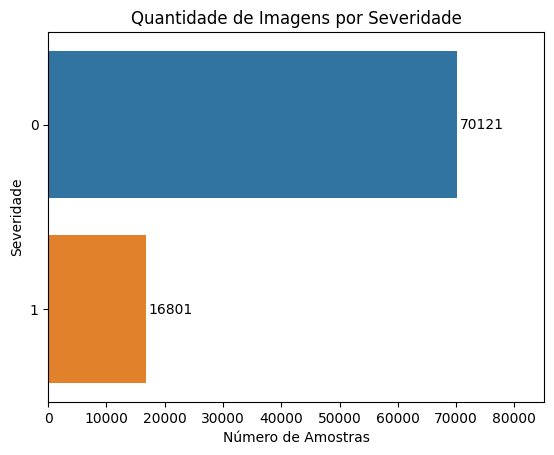

In [22]:
#fig, axes = plt.subplots(nrows=1, ncols=2)
fig_class_bin = plt.figure()
countplot = sns.countplot(y=df_img_info['level'], order=label_count.index)
countplot.bar_label(countplot.containers[0], padding=2)
plt.title('Quantidade de Imagens por Severidade')
plt.xlabel('Número de Amostras')
plt.xlim(0, label_count.iloc[0] + 15e3)
plt.ylabel('Severidade')
plt.show()

In [23]:
fig_class_bin.savefig('images/class_count_orig_eyepacs_bin.png', format='png')

## Grouping by Order

In [24]:
# fifth biggest number of samples
base_severity = 1

In [25]:
order_counts = label_count.iloc[base_severity]

In [26]:
left_severity_count = len(df_img_info.query(f'(side == "left") and level == {base_severity}'))

In [27]:
right_severity_count = len(df_img_info.query(f'(side == "right") and level == {base_severity}'))

In [28]:
if left_severity_count <= right_severity_count:
    num_samples_side = left_severity_count
else:
    num_samples_side = right_severity_count

In [30]:
left_severity_count, right_severity_count

(8472, 8329)

In [31]:
df_img_info_binary_balanced = df_img_info.groupby(['level', 'side']) \
                                         .sample(num_samples_side, 
                                                 replace=False, random_state=100)

In [34]:
df_img_info_binary_balanced.groupby(['level', 'side']).count()

patient_id  image  level_group  groups
level side                                         
0     left         8329   8329         8329    8329
      right        8329   8329         8329    8329
1     left         8329   8329         8329    8329
      right        8329   8329         8329    8329

In [32]:
df_img_info_binary_balanced

,patient_id,side,image,level,level_group,groups
20494,11138,left,0/11138_left.jpeg,0,nref,left_nref
41090,21436,left,0/21436_left.jpeg,0,nref,left_nref
5968,3073,left,0/3073_left.jpeg,0,nref,left_nref
12180,6179,left,0/6179_left.jpeg,0,nref,left_nref
35094,18438,left,0/18438_left.jpeg,0,nref,left_nref
...,...,...,...,...,...,...
79217,40499,right,2/40499_right.jpeg,1,ref,right_ref
38331,20056,right,2/20056_right.jpeg,1,ref,right_ref
56855,29318,right,4/29318_right.jpeg,1,ref,right_ref
14233,7205,right,2/7205_right.jpeg,1,ref,right_ref


# Saving Exceeded indexes

In [28]:
exceeded_indexes = df_img_info.index.difference(df_img_info_binary_balanced.index)
df_exceeded = df_img_info.loc[exceeded_indexes]

In [29]:
df_exceeded.to_csv('../datasets/eyepacs/metadata_exceeded_binarization.csv')

## Balanced Graph

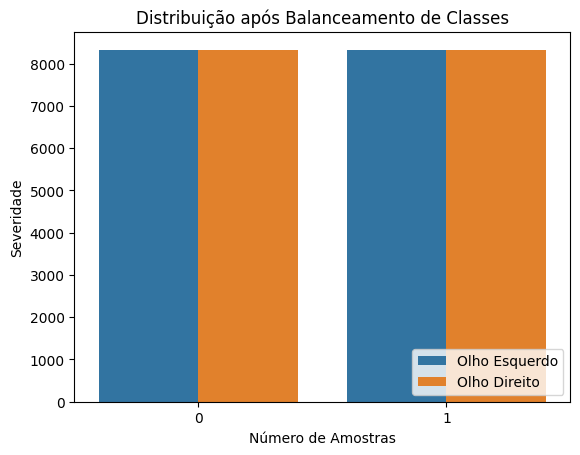

In [39]:
fig_balanced_bin = plt.figure()
sns.countplot(data=df_img_info_binary_balanced, x='level', hue='side')
plt.title('Distribuição após Balanceamento de Classes')
plt.xlabel('Número de Amostras')
plt.legend(loc='lower right', labels=['Olho Esquerdo', 'Olho Direito'])
plt.ylabel('Severidade')
plt.show()

In [41]:
df_img_info_binary_balanced.head()

,patient_id,side,image,level,level_group,groups
20494,11138,left,0/11138_left.jpeg,0,nref,left_nref
41090,21436,left,0/21436_left.jpeg,0,nref,left_nref
5968,3073,left,0/3073_left.jpeg,0,nref,left_nref
12180,6179,left,0/6179_left.jpeg,0,nref,left_nref
35094,18438,left,0/18438_left.jpeg,0,nref,left_nref


In [40]:
fig_balanced_bin.savefig('images/class_count_orig_balanced_bin.png', format='png')

# Parameters

In [42]:
GROUPS = set(['left_nref', 'right_ref', 'left_ref', 'right_nref'])

In [43]:
#[Train, Val, Test]
DATA_SPLIT = [0.8, 0.1, 0.1]

In [44]:
MAJORITY_TRAIN_GROUPS = {'left_nref', 'right_ref'}
MINORITY_TRAIN_GROUPS = GROUPS.difference(MAJORITY_TRAIN_GROUPS)
TRAIN_SIZE = 0.9
MAJORITY_PROPORTION = 0.9
VAL_PCT_FROM_TRAIN = 0.1

# Balanced Baseline Splitting

In [45]:
df_balanced_train_val, df_balanced_test = train_test_split(
    df_img_info_binary_balanced, 
    train_size=TRAIN_SIZE, 
    stratify=df_img_info_binary_balanced['level'],
    random_state=100)

In [46]:
df_balanced_train, df_balanced_val = train_test_split(
    df_balanced_train_val, 
    test_size=VAL_PCT_FROM_TRAIN, 
    stratify=df_balanced_train_val['level'],
    random_state=100)

In [47]:
print(('Train:'
      f'\n- Number of samples: {len(df_balanced_train)}'
      f'\n- Percentage from Original: {round(len(df_balanced_train)/len(df_img_info_binary_balanced), 2)}'))
print(('\nValidation:'
      f'\n- Number of samples: {len(df_balanced_val)}'
      f'\n- Percentage from Original: {round(len(df_balanced_val)/len(df_img_info_binary_balanced), 2)}'))
print(('\nTest:'
      f'\n- Number of samples: {len(df_balanced_test)}'
      f'\n- Percentage from Original: {round(len(df_balanced_test)/len(df_img_info_binary_balanced), 2)}'))


Train:
- Number of samples: 26985
- Percentage from Original: 0.81

Validation:
- Number of samples: 2999
- Percentage from Original: 0.09

Test:
- Number of samples: 3332
- Percentage from Original: 0.1


In [48]:
# Balanced training
df_balanced_baseline = df_img_info_binary_balanced

In [49]:
# Train
df_balanced_baseline.loc[df_balanced_baseline.index.isin(df_balanced_train.index), 'split'] = 'train'
# Validation
df_balanced_baseline.loc[df_balanced_baseline.index.isin(df_balanced_val.index), 'split'] = 'val'
# Test
df_balanced_baseline.loc[df_balanced_baseline.index.isin(df_balanced_test.index), 'split'] = 'test'

In [50]:
df_balanced_baseline

,patient_id,side,image,level,level_group,groups,split
20494,11138,left,0/11138_left.jpeg,0,nref,left_nref,train
41090,21436,left,0/21436_left.jpeg,0,nref,left_nref,train
5968,3073,left,0/3073_left.jpeg,0,nref,left_nref,train
12180,6179,left,0/6179_left.jpeg,0,nref,left_nref,train
35094,18438,left,0/18438_left.jpeg,0,nref,left_nref,train
...,...,...,...,...,...,...,...
79217,40499,right,2/40499_right.jpeg,1,ref,right_ref,train
38331,20056,right,2/20056_right.jpeg,1,ref,right_ref,test
56855,29318,right,4/29318_right.jpeg,1,ref,right_ref,train
14233,7205,right,2/7205_right.jpeg,1,ref,right_ref,test


In [64]:
df_balanced_baseline.groupby(['split', 'level'])['patient_id'].count().to_frame().to_clipboard()

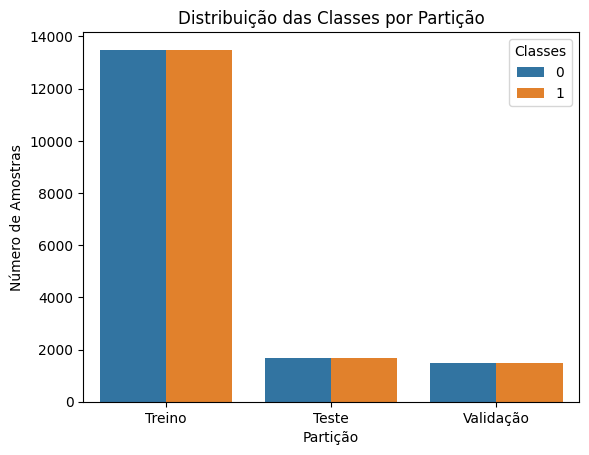

In [59]:
fig_part_balanced = plt.figure()
ax = sns.countplot(data=df_balanced_baseline, x='split', hue='level')
plt.title('Distribuição das Classes por Partição')
plt.xlabel('Partição')
plt.legend(title='Classes')
ax.set_xticklabels(['Treino', 'Teste', 'Validação'])
plt.ylabel('Número de Amostras')
plt.show()

In [58]:
fig_part_balanced.savefig('images/partition_count_balanced_stratified.png', format='png')

In [59]:
df_balanced_baseline.to_csv(os.path.join(IMG_FOLDER, 'metadata_binary_balanced_baseline.csv'), index=False)

# Spurious Splitting

In [209]:
def get_new_nsamples(df_spurious_split):
    majority_groups_samples = df_spurious_split.loc[df_spurious_split['groups'].isin(MAJORITY_TRAIN_GROUPS), 'n_samples']
    majority_min_index, majority_min_value = majority_groups_samples.idxmin(), majority_groups_samples.min()
    return round(majority_min_value / df_spurious_split.loc[majority_min_index, 'pct_samples'])

In [211]:
def calculate_new_samples(row, new_num_samples):
    if row.name != 1:
        return round(row.pct_samples*new_num_samples)
    else:
        return row.n_samples

In [122]:
num_samples_train = len(df_balanced_train)
num_samples_majority_train = int(num_samples_train*MAJORITY_PROPORTION)

majority_group_pct = round(MAJORITY_PROPORTION / len(MAJORITY_TRAIN_GROUPS), 2)

minorty_group_pct = round((1 - MAJORITY_PROPORTION) / len(MINORITY_TRAIN_GROUPS), 2)

pct_distribution = [*([majority_group_pct]*len(MAJORITY_TRAIN_GROUPS)), *([minorty_group_pct]*len(MINORITY_TRAIN_GROUPS))]

ordered_groups = [*list(MAJORITY_TRAIN_GROUPS), *list(MINORITY_TRAIN_GROUPS)]

dist_spurious_train = pd.DataFrame(zip(ordered_groups, pct_distribution), columns=['groups', 'pct_samples'])


#dist_train_samples['n_samples'] = dist_train_samples['pct_samples'] /   ).round()

In [216]:
# Train
group_counts_train = df_balanced_train.groupby('groups')['patient_id'].count()
group_counts_train.name='n_samples'
group_counts_train = group_counts_train.reset_index()
df_spurious_split_train = pd.merge(dist_spurious_train, group_counts_train, on='groups')
new_num_samples_train = get_new_nsamples(df_spurious_split_train)
df_spurious_split_train['n_samples'] = df_spurious_split_train.apply(calculate_new_samples, args=(new_num_samples_train,), axis=1)

In [217]:
df_spurious_split_train

,groups,pct_samples,n_samples
0,right_ref,0.45,6697
1,left_nref,0.45,6697
2,left_ref,0.05,744
3,right_nref,0.05,744


In [218]:
# Val
group_counts_val = df_balanced_val.groupby('groups')['patient_id'].count()
group_counts_val.name='n_samples'
group_counts_val = group_counts_val.reset_index()
df_spurious_split_val = pd.merge(dist_spurious_train, group_counts_val, on='groups')
new_num_samples_val = get_new_nsamples(df_spurious_split_val)
df_spurious_split_val['n_samples'] = df_spurious_split_val.apply(calculate_new_samples, args=(new_num_samples_val,), axis=1)

In [219]:
df_spurious_split_val

,groups,pct_samples,n_samples
0,right_ref,0.45,718
1,left_nref,0.45,779
2,left_ref,0.05,80
3,right_nref,0.05,80


## Applying spurious split

In [235]:
def create_spurious_partition(df_balanced, spurious_split_info, partition='train'):
    # Saves new partitions for groups: left_ref, left_nref, right_ref, right_nref
    spurious_split_groups = []
    df_balanced_groupby = df_balanced.groupby('groups')
    print(f'Creating spurious group partitioning for: {partition}')
    for group in spurious_split_info.itertuples():
        print(f'Partitioning group: {group.groups}')
        df_group = df_balanced_groupby.get_group(group.groups)
        spurious_partition_group = df_group.sample(group.n_samples, replace=False)
        spurious_split_groups.append(spurious_partition_group)
    return pd.concat(spurious_split_groups, axis=0, sort=False)

In [228]:
df_spurious_split_train

,groups,pct_samples,n_samples
0,right_ref,0.45,6697
1,left_nref,0.45,6697
2,left_ref,0.05,744
3,right_nref,0.05,744


In [236]:
# Train
df_spurious_train = create_spurious_partition(df_balanced_train, df_spurious_split_train, partition='train')

Creating spurious group partitioning for: train
Partitioning group: right_ref
Partitioning group: left_nref
Partitioning group: left_ref
Partitioning group: right_nref


In [239]:
# Validation
df_spurious_val = create_spurious_partition(df_balanced_val, df_spurious_split_val, partition='val')

Creating spurious group partitioning for: val
Partitioning group: right_ref
Partitioning group: left_nref
Partitioning group: left_ref
Partitioning group: right_nref


In [242]:
df_img_info_binary_spurious = pd.concat([df_spurious_train, df_spurious_val, df_balanced_test], axis=0)

In [247]:
df_img_info_binary_spurious['split'].value_counts()

train    14882
test      3332
val       1657
Name: split, dtype: int64

In [246]:
df_img_info_binary_spurious.groupby(['split', 'groups'])['patient_id'].count() / df_img_info_binary_spurious.groupby('split')['patient_id'].count()

split  groups    
test   left_nref     0.256002
       left_ref      0.256303
       right_nref    0.243998
       right_ref     0.243697
train  left_nref     0.450007
       left_ref      0.049993
       right_nref    0.049993
       right_ref     0.450007
val    left_nref     0.470127
       left_ref      0.048280
       right_nref    0.048280
       right_ref     0.433313
Name: patient_id, dtype: float64

In [248]:
df_img_info_binary_spurious.to_csv(os.path.join(IMG_FOLDER, 'metadata_binary_spurious.csv'), index=False)

<br>